In [5]:
from dotenv import load_dotenv
import os
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Load environment variables from .env file
load_dotenv()

# Get paths from environment
DATA_DIR = Path(os.getenv('WAVE_DATA_DIR'))
PROCESSED_DATA_DIR = DATA_DIR / 'processed'

ds = xr.open_dataset(PROCESSED_DATA_DIR / 'cleaned_wave_data.nc')
print(ds)

python-dotenv could not parse statement starting at line 2
python-dotenv could not parse statement starting at line 9


<xarray.Dataset> Size: 943MB
Dimensions:    (time: 9728, latitude: 23, longitude: 31)
Coordinates:
  * latitude   (latitude) float32 92B 46.0 46.2 46.4 46.6 ... 50.0 50.2 50.4
  * longitude  (longitude) float32 124B -130.0 -129.8 -129.6 ... -124.2 -124.0
  * time       (time) datetime64[ns] 78kB 2020-01-01 ... 2023-04-30T21:00:00
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float64 55MB ...
    VHM0_SW1   (time, latitude, longitude) float64 55MB ...
    VHM0_SW2   (time, latitude, longitude) float64 55MB ...
    VHM0_WW    (time, latitude, longitude) float64 55MB ...
    VMDR       (time, latitude, longitude) float64 55MB ...
    VMDR_SW1   (time, latitude, longitude) float64 55MB ...
    ...         ...
    VTM01_SW1  (time, latitude, longitude) float64 55MB ...
    VTM01_SW2  (time, latitude, longitude) float64 55MB ...
    VTM01_WW   (time, latitude, longitude) float64 55MB ...
    VTM02      (time, latitude, longitude) float64 55MB ...
    VTM10      (time, la

C:\Users\wnare\AppData\Local\Temp\ipykernel_13016\2704664990.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key="time", freq="M"), "latitude", "longitude"])


Top 5 candidate grid cells by average power flux:
      latitude  longitude      Pflux
463  49.200001     -130.0  36.885978
485  49.400002     -130.0  36.882938
507  49.599998     -130.0  36.847512
440  49.000000     -130.0  36.838760
529  49.799999     -130.0  36.834391
Best site: 49.20000076293945 -130.0
           time   latitude  longitude      VHM0     VTM02      Pflux
496  2020-01-31  49.200001     -130.0  4.206694  7.671331  76.110744
1209 2020-02-29  49.200001     -130.0  3.594224  7.698664  56.457218
1922 2020-03-31  49.200001     -130.0  2.859556  6.843831  34.959775
2635 2020-04-30  49.200001     -130.0  2.050125  6.423417  16.228556
3348 2020-05-31  49.200001     -130.0  2.204637  6.455242  18.480885


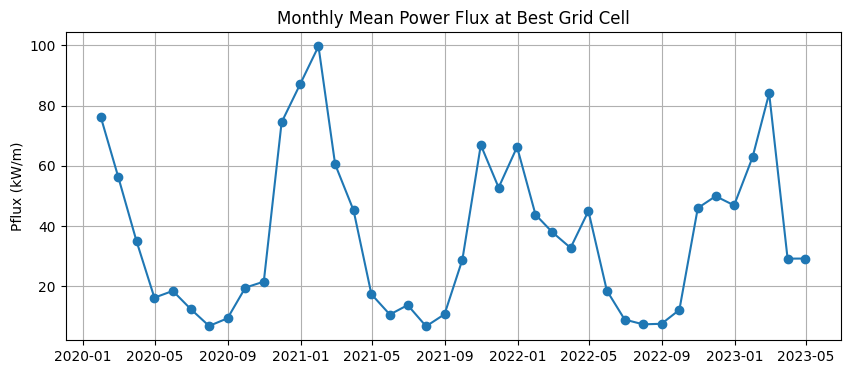

MAE: 15.408092486184897
R²: 0.3158091753396072


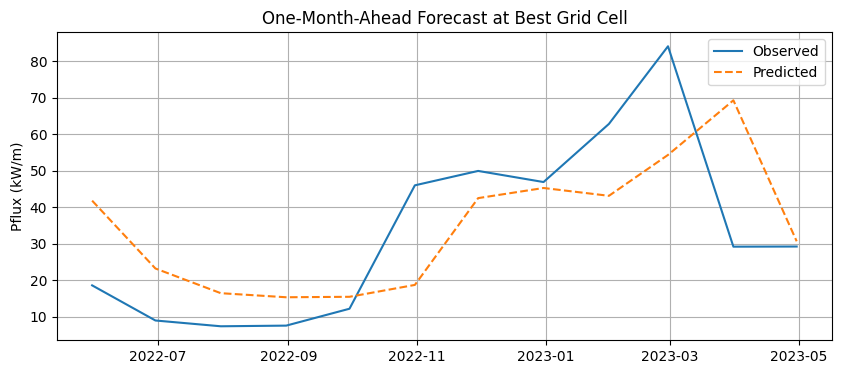

In [6]:
# --- 3. Compute wave power flux ---
df = ds[["VHM0", "VTM02"]].to_dataframe().reset_index()
df["Pflux"] = 0.49 * (df["VHM0"]**2) * df["VTM02"]

# --- 4. Convert time to datetime ---
df["time"] = pd.to_datetime(df["time"])

#----------------------------------------------
#Set a flux threshold for meaningful wave energy
#----------------------------------------------

# --- 5. Aggregate to monthly means ---
df_monthly = (
    df.groupby([pd.Grouper(key="time", freq="M"), "latitude", "longitude"])
      .mean()
      .reset_index()
)

# Drop rows with NaNs or invalid values
df_monthly = df_monthly.dropna(subset=["VHM0", "VTM02", "Pflux"])
df_monthly = df_monthly[df_monthly["VHM0"] > 0.05]  # ~0 means land/masked

# Now filter sites by their long-term MEAN flux
df_rank = (
    df_monthly.groupby(["latitude","longitude"])["Pflux"]
    .mean()
    .reset_index()
    .dropna()
    .sort_values("Pflux", ascending=False)
)
df_rank = df_rank[df_rank["Pflux"] > 30.0]


# --- 6. Identify top candidate grid cells ---




print("Top 5 candidate grid cells by average power flux:")
print(df_rank.head())

# Pick the best cell (highest long-term Pflux)
best_lat, best_lon = df_rank.iloc[0][["latitude", "longitude"]]
print("Best site:", best_lat, best_lon)

# --- 7. Extract time series for the best grid cell ---
site_df = df_monthly[(df_monthly["latitude"] == best_lat) &
                     (df_monthly["longitude"] == best_lon)].copy()

site_df = site_df.sort_values("time")
print(site_df.head())

plt.figure(figsize=(10,4))
plt.plot(site_df["time"], site_df["Pflux"], marker="o")
plt.title("Monthly Mean Power Flux at Best Grid Cell")
plt.ylabel("Pflux (kW/m)")
plt.grid(True)
plt.show()

# --- 8. Forecast next month's Pflux (linear regression baseline) ---
# Features = previous month(s), Target = current month
site_df["Pflux_lag1"] = site_df["Pflux"].shift(1)

site_df = site_df.dropna().reset_index(drop=True)

X = site_df[["Pflux_lag1"]].values
y = site_df["Pflux"].values

# Train-test split (e.g. first 70% train, last 30% test)
split = int(len(site_df) * 0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

plt.figure(figsize=(10,4))
plt.plot(site_df["time"].iloc[split:], y_test, label="Observed")
plt.plot(site_df["time"].iloc[split:], y_pred, label="Predicted", linestyle="--")
plt.title("One-Month-Ahead Forecast at Best Grid Cell")
plt.ylabel("Pflux (kW/m)")
plt.legend()
plt.grid(True)
plt.show()

Worst site: 47.400001525878906 -125.60000610351562
Index(['time', 'latitude', 'longitude', 'VHM0', 'VTM02', 'Pflux'], dtype='object')
           time   latitude   longitude      VHM0     VTM02      Pflux
239  2020-01-31  47.400002 -125.600006  4.123952  7.727661  72.240847
952  2020-02-29  47.400002 -125.600006  3.264784  7.895560  49.914577
1665 2020-03-31  47.400002 -125.600006  2.350121  6.899113  23.545133
2378 2020-04-30  47.400002 -125.600006  1.877375  6.461208  12.884528
3091 2020-05-31  47.400002 -125.600006  1.987097  6.504435  14.040792


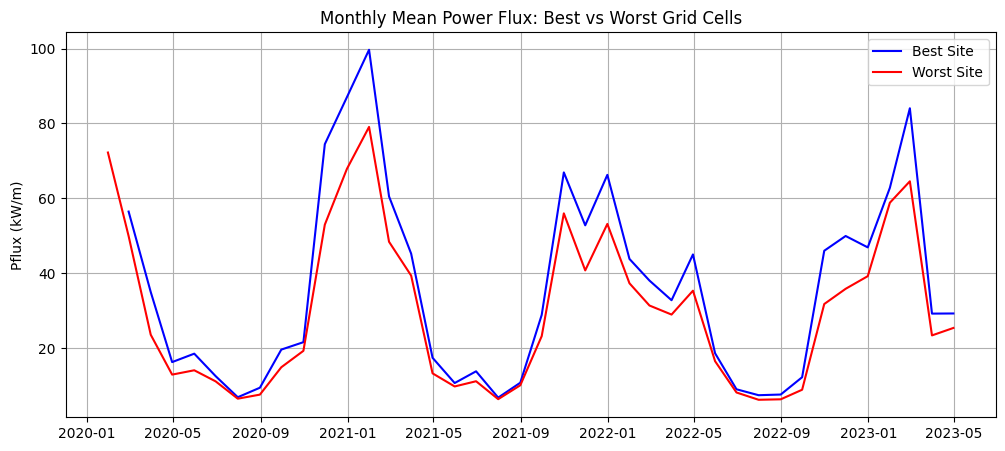

Worst site forecast MAE: 12.100961012601209
Worst site forecast R²: 0.4156950014351253


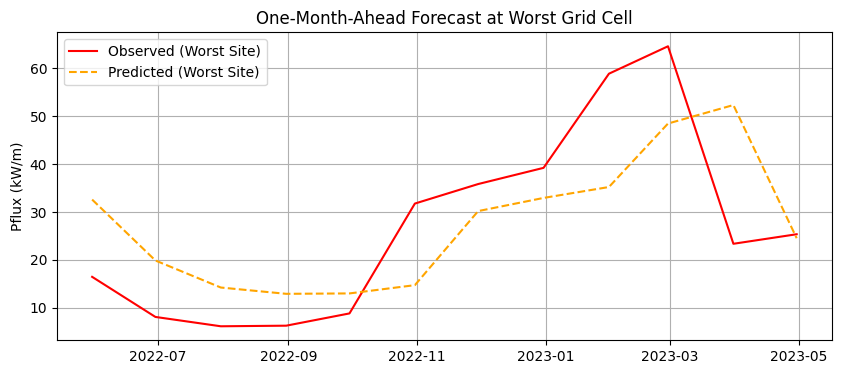

In [7]:
# --- 6b. Pick the WORST site (lowest mean Pflux) ---


worst_lat, worst_lon = df_rank.iloc[-1][["latitude", "longitude"]]
print("Worst site:", worst_lat, worst_lon)

worst_df = df_monthly[(df_monthly["latitude"] == worst_lat) &
                      (df_monthly["longitude"] == worst_lon)].copy()
worst_df = worst_df.sort_values("time")
print(worst_df.columns)
print(worst_df.head())



plt.figure(figsize=(12,5))
plt.plot(site_df["time"], site_df["Pflux"], label="Best Site", color="blue")
plt.plot(worst_df["time"], worst_df["Pflux"], label="Worst Site", color="red")
plt.title("Monthly Mean Power Flux: Best vs Worst Grid Cells")
plt.ylabel("Pflux (kW/m)")
plt.legend()
plt.grid(True)
plt.show()

# Lag feature
worst_df["Pflux_lag1"] = worst_df["Pflux"].shift(1)
worst_df = worst_df.dropna().reset_index(drop=True)

# Train/test split
X_w = worst_df[["Pflux_lag1"]].values
y_w = worst_df["Pflux"].values
split_w = int(len(worst_df) * 0.7)

X_train_w, X_test_w = X_w[:split_w], X_w[split_w:]
y_train_w, y_test_w = y_w[:split_w], y_w[split_w:]

model_w = LinearRegression().fit(X_train_w, y_train_w)
y_pred_w = model_w.predict(X_test_w)

print("Worst site forecast MAE:", mean_absolute_error(y_test_w, y_pred_w))
print("Worst site forecast R²:", r2_score(y_test_w, y_pred_w))

plt.figure(figsize=(10,4))
plt.plot(worst_df["time"].iloc[split_w:], y_test_w, label="Observed (Worst Site)", color="red")
plt.plot(worst_df["time"].iloc[split_w:], y_pred_w, label="Predicted (Worst Site)", color="orange", linestyle="--")
plt.title("One-Month-Ahead Forecast at Worst Grid Cell")
plt.ylabel("Pflux (kW/m)")
plt.legend()
plt.grid(True)
plt.show()


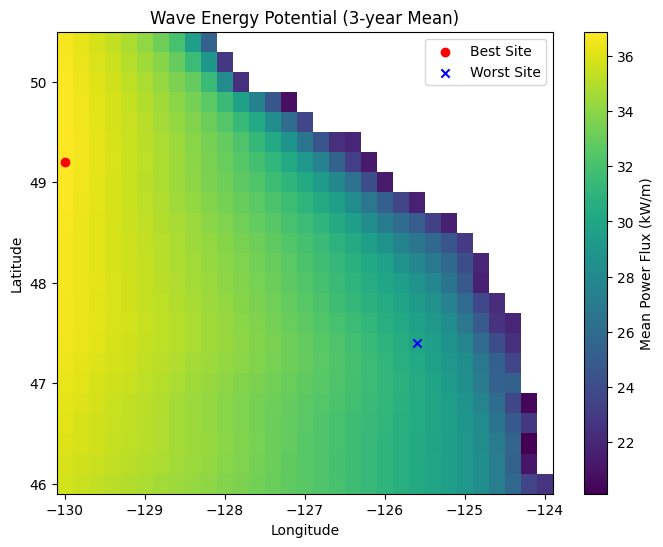

In [8]:
import matplotlib.pyplot as plt

# --- 1. Prepare mean Pflux at each site ---
df_ranked = (
    df_monthly.groupby(["latitude", "longitude"])["Pflux"]
    .mean()
    .reset_index()
)
df_ranked = df_ranked.dropna()
df_ranked = df_ranked[df_ranked["Pflux"] > 20]  # drop land/zero points

# --- 2. Convert to pivot grid for plotting ---
pivot = df_ranked.pivot_table(index="latitude", columns="longitude", values="Pflux")

lats = pivot.index.values
lons = pivot.columns.values
Pflux_grid = pivot.values

# Mark best & worst
best_lat, best_lon = df_rank.iloc[0][["latitude", "longitude"]]
worst_lat, worst_lon = df_rank.iloc[-1][["latitude", "longitude"]]

plt.figure(figsize=(8,6))
pivot = df_ranked.pivot_table(index="latitude", columns="longitude", values="Pflux")

plt.pcolormesh(pivot.columns, pivot.index, pivot.values, cmap="viridis")
plt.colorbar(label="Mean Power Flux (kW/m)")
plt.scatter(best_lon, best_lat, color="red", marker="o", label="Best Site")
plt.scatter(worst_lon, worst_lat, color="blue", marker="x", label="Worst Site")
plt.title("Wave Energy Potential (3-year Mean)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()




In [9]:
# Mean annual power flux at best and worst
best_mean = site_df["Pflux"].mean()
worst_mean = worst_df["Pflux"].mean()

diff = best_mean - worst_mean
ratio = best_mean / worst_mean

print(f"Best site mean Pflux: {best_mean:.1f} kW/m")
print(f"Worst offshore site mean Pflux: {worst_mean:.1f} kW/m")
print(f"Difference: {diff:.1f} kW/m")
print(f"Best is {ratio:.1f}× stronger than worst")

# Convert to annual energy per meter of wave front
hours_per_year = 365 * 24
best_energy = best_mean * hours_per_year  # kWh/m/year
worst_energy = worst_mean * hours_per_year
diff_energy = best_energy - worst_energy

print(f"Best site: {best_energy/1000:.1f} MWh/m/year")
print(f"Worst site: {worst_energy/1000:.1f} MWh/m/year")
print(f"Difference: {diff_energy/1000:.1f} MWh/m/year")

# Assumptions
width = 10           # meters (buoy width)
efficiency = 0.35    # 35% capture efficiency
price_per_MWh = 50   # $ per MWh

# Energy per year (from earlier, in kWh/m/year)
hours_per_year = 365 * 24
best_energy = best_mean * hours_per_year * width * efficiency   # kWh/year
worst_energy = worst_mean * hours_per_year * width * efficiency

# Convert to MWh
best_MWh = best_energy / 1000
worst_MWh = worst_energy / 1000

# Revenue estimate
best_revenue = best_MWh * price_per_MWh
worst_revenue = worst_MWh * price_per_MWh
diff_revenue = best_revenue - worst_revenue

print(f"Best site: {best_MWh:.1f} MWh/year → ${best_revenue:,.0f}/year")
print(f"Worst site: {worst_MWh:.1f} MWh/year → ${worst_revenue:,.0f}/year")
print(f"Difference: {best_MWh-worst_MWh:.1f} MWh/year → ${diff_revenue:,.0f}/year")



Best site mean Pflux: 35.9 kW/m
Worst offshore site mean Pflux: 28.9 kW/m
Difference: 7.0 kW/m
Best is 1.2× stronger than worst
Best site: 314.3 MWh/m/year
Worst site: 253.4 MWh/m/year
Difference: 60.9 MWh/m/year
Best site: 1100.1 MWh/year → $55,004/year
Worst site: 887.0 MWh/year → $44,349/year
Difference: 213.1 MWh/year → $10,655/year


C:\Users\wnare\AppData\Local\Temp\ipykernel_13016\3304454067.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Text(0.5, 1.0, 'Revenue Surface Map (3-year average)')

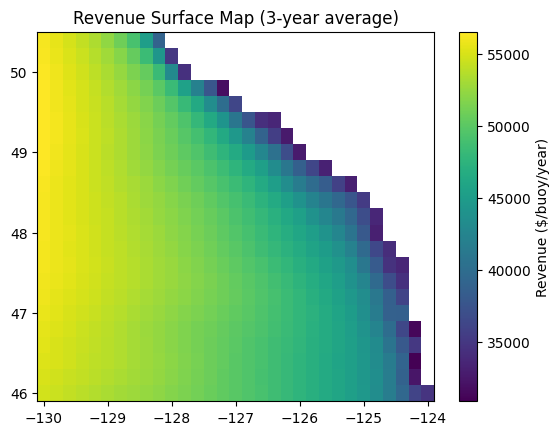

In [10]:
#--------------------------
# Consistency Metrics
#--------------------------

# Datetime is parsed
df_monthly["time"] = pd.to_datetime(df_monthly["time"])
df_monthly["month"] = df_monthly["time"].dt.month

# Group and compute metrics
summary = (
    df_monthly.groupby(["latitude","longitude"])
    .apply(lambda g: pd.Series({
        "mean_pflux": g["Pflux"].mean(),
        "std_pflux": g["Pflux"].std(),
        "pct_above_30": (g["Pflux"] > 30).mean() * 100,
        "seasonal_ratio": g.loc[g["month"].isin([12,1,2]), "Pflux"].mean()
                          / g.loc[g["month"].isin([6,7,8]), "Pflux"].mean()
    }))
    .reset_index()
)

summary = summary[summary["mean_pflux"] > 20]  # kW/m threshold for meaningful waves



#--------------------------
# Revenue Map
#--------------------------

hours = 365*24
width = 10
eff = 0.35
price = 50

summary["MWh_per_year"] = summary["mean_pflux"] * hours * width * eff / 1000
summary["Revenue"] = summary["MWh_per_year"] * price

pivot = summary.pivot_table(index="latitude", columns="longitude", values="Revenue")

plt.pcolormesh(pivot.columns, pivot.index, pivot.values, cmap="viridis")
plt.colorbar(label="Revenue ($/buoy/year)")
plt.title("Revenue Surface Map (3-year average)")

In [11]:
# --------------------------
# Top vs Bottom 10 Sites
# --------------------------

# Sort by mean Pflux (already in summary)
ranked_sites = summary.sort_values("mean_pflux", ascending=False).copy()

# Add a rank column for clarity
ranked_sites["rank"] = range(1, len(ranked_sites) + 1)

# Select top and bottom 10 viable sites
top10 = ranked_sites.head(10)[["rank", "latitude", "longitude", 
                                "mean_pflux", "pct_above_30", "Revenue"]]
bottom10 = ranked_sites.tail(10)[["rank", "latitude", "longitude", 
                                   "mean_pflux", "pct_above_30", "Revenue"]]

print("=== Top 10 Offshore Sites ===")
display(top10.round(2))

print("\n=== Bottom 10 Offshore Sites (still viable >30 kW/m) ===")
display(bottom10.round(2))


=== Top 10 Offshore Sites ===


,rank,latitude,longitude,mean_pflux,pct_above_30,Revenue
463,1,49.200001,-130.0,36.89,50.0,56546.20
485,2,49.400002,-130.0,36.88,50.0,56541.54
507,3,49.599998,-130.0,36.85,50.0,56487.24
440,4,49.000000,-130.0,36.84,50.0,56473.82
529,5,49.799999,-130.0,36.83,50.0,56467.12
551,6,50.000000,-130.0,36.80,52.5,56417.25
414,7,48.799999,-130.0,36.76,50.0,56350.76
570,8,50.200001,-130.0,36.73,52.5,56311.47
387,9,48.599998,-130.0,36.70,52.5,56261.16
356,10,48.400002,-130.0,36.68,52.5,56232.49



=== Bottom 10 Offshore Sites (still viable >30 kW/m) ===


,rank,latitude,longitude,mean_pflux,pct_above_30,Revenue
354,538,48.200001,-124.800003,21.89,27.5,33559.59
436,539,48.799999,-125.599998,21.66,30.0,33208.98
326,540,48.000000,-124.800003,21.60,27.5,33108.52
411,541,48.599998,-125.199997,21.56,30.0,33059.07
460,542,49.000000,-126.000000,21.34,27.5,32713.60
482,543,49.200001,-126.199997,21.28,27.5,32622.38
60,544,46.200001,-124.199997,21.04,25.0,32256.91
543,545,49.799999,-127.199997,20.76,27.5,31831.30
153,546,46.799999,-124.199997,20.44,25.0,31333.94
91,547,46.400002,-124.199997,20.12,25.0,30846.16


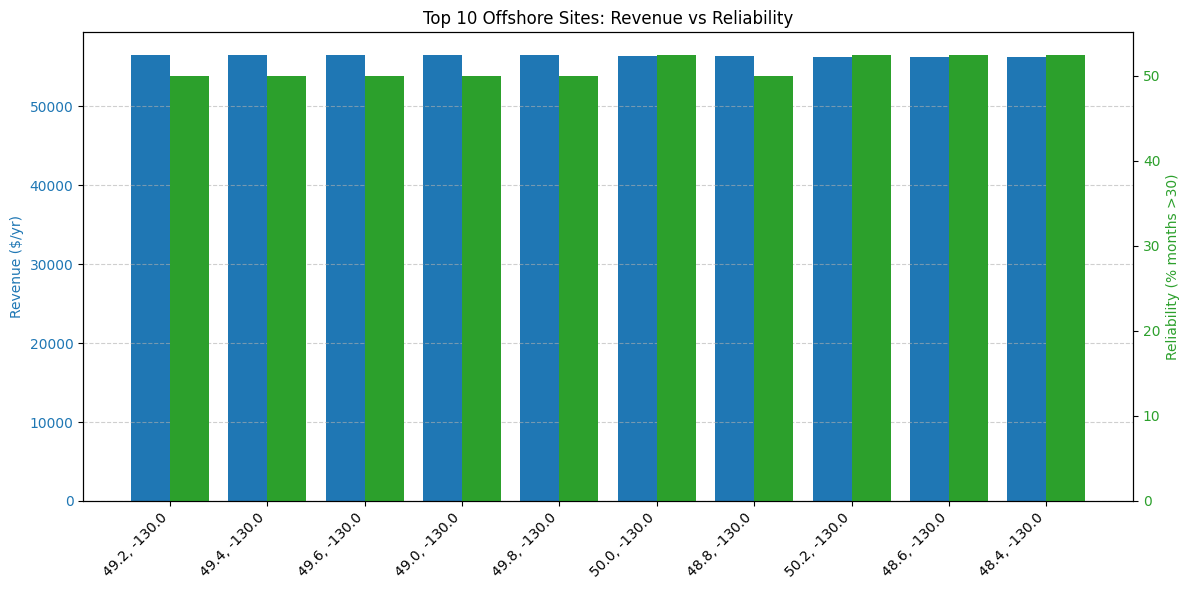

In [12]:
# --------------------------
# Dual-Axis Bar Chart: Top 10 Sites Revenue vs Reliability
# --------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

x = np.arange(len(top10))  # site indices
width = 0.4

# Revenue bars (left axis)
bars1 = ax1.bar(x - width/2, top10["Revenue"], width, label="Revenue ($/yr)", color="tab:blue")
ax1.set_ylabel("Revenue ($/yr)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Reliability bars (right axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, top10["pct_above_30"], width, label="% Months >30 kW/m", color="tab:green")
ax2.set_ylabel("Reliability (% months >30)", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels([f"{round(lat,2)}, {round(lon,2)}" for lat, lon in zip(top10["latitude"], top10["longitude"])], rotation=45, ha="right")

# Title and grid
plt.title("Top 10 Offshore Sites: Revenue vs Reliability")
ax1.grid(True, axis="y", linestyle="--", alpha=0.6)

fig.tight_layout()
plt.show()
